# Step 4 — Parameter Comparison Experiment

## 0) Configs

In [ ]:
CFG = {
    "models": [
        ("sentence-transformers/all-MiniLM-L6-v2", "miniLM6v2", 384),
        ("sentence-transformers/all-mpnet-base-v2", "mpnetv2", 512),
    ],
    "chunk_max_chars": 600, # Keep in accordance with Step3, may change to experiment chunking size later
    "retrieval_topk": [3, 5, 10],
    "selection_strategies": ["concat", "mmr"],
    "max_ctx_chars": 2000,
    "n_samples": None,   # Set to 200 to test
    "batch_size": 64,
}
print(CFG)


{'models': [('sentence-transformers/all-MiniLM-L6-v2', 'miniLM6v2', 384), ('sentence-transformers/all-mpnet-base-v2', 'mpnetv2', 512)], 'chunk_max_chars': 600, 'retrieval_topk': [3, 5, 10], 'selection_strategies': ['concat', 'mmr'], 'max_ctx_chars': 2000, 'n_samples': None, 'batch_size': 64}


## 1) Install dependencies

In [ ]:
!pip install -q datasets evaluate transformers sentence-transformers faiss-cpu pandas numpy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 43.2 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import evaluate
import numpy as np
import pandas as pd
import time
from typing import List, Tuple
from sentence_transformers import SentenceTransformer
import faiss
import matplotlib.pyplot as plt


## 2) Answer generator using local Flan-T5 Transformer

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

tok = AutoTokenizer.from_pretrained("google/flan-t5-base")
mdl = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
gen_pipe = pipeline("text2text-generation", model=mdl, tokenizer=tok)

def generate_answer(prompt, max_new_tokens=128):
    out = gen_pipe(prompt, max_new_tokens=max_new_tokens)[0]["generated_text"]
    return out.strip()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0


## 3) Load `text-corpus` and `question-answer` subsets from RAG-Wikipedia

In [ ]:
from datasets import load_dataset

corpus_ds = load_dataset("rag-datasets/rag-mini-wikipedia", name="text-corpus")
print("Keys in corpus dataset:", corpus_ds.keys())

qa_ds = load_dataset("rag-datasets/rag-mini-wikipedia", name="question-answer")
print("Keys in qa dataset:", qa_ds.keys())

corpus = corpus_ds["passages"]
qa = qa_ds["test"]

print("Corpus size:", len(corpus))
print("QA size:", len(qa))

README.md:   0%|          | 0.00/719 [00:00<?, ?B/s]

data/passages.parquet/part.0.parquet:   0%|          | 0.00/797k [00:00<?, ?B/s]

Generating passages split:   0%|          | 0/3200 [00:00<?, ? examples/s]

Keys in corpus dataset: dict_keys(['passages'])


data/test.parquet/part.0.parquet:   0%|          | 0.00/54.4k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/918 [00:00<?, ? examples/s]

Keys in qa dataset: dict_keys(['test'])
Corpus size: 3200
QA size: 918


## 4) Text chunking

In [ ]:
def simple_chunks(text: str, max_chars: int) -> List[str]:
    if not text:
        return []
    return [text[i:i+max_chars] for i in range(0, len(text), max_chars)]

def build_docs(corpus_split, max_chars: int):
    docs = []
    for i, row in enumerate(corpus_split):
        t = row.get("text") or row.get("passage") or ""
        chs = simple_chunks(t, max_chars)
        for j, ch in enumerate(chs):
            docs.append({"id": f"{i}-{j}", "text": ch})
    return docs

docs = build_docs(corpus, CFG["chunk_max_chars"])
print("Total chunks:", len(docs))


Total chunks: 4046


## 5) Index building

In [ ]:
def build_index(model_id: str, expected_dim: int):
    model = SentenceTransformer(model_id)
    texts = [d["text"] for d in docs]
    X = model.encode(texts, batch_size=CFG["batch_size"], show_progress_bar=True, normalize_embeddings=True, truncate=True) # Truncate a few overly long text segments to fit in model
    X = X.astype("float32")
    index = faiss.IndexFlatIP(X.shape[1])
    index.add(X)
    return {"model": model, "index": index, "emb": X}

per_model = {}
for mid, short, dim in CFG["models"]:
    print("Building index for:", short)
    per_model[short] = build_index(mid, dim)


Building index for: miniLM6v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/64 [00:00<?, ?it/s]

Building index for: mpnetv2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/64 [00:00<?, ?it/s]

## 6) Search and MMR

In [ ]:
def faiss_search(bundle, query: str, top_k: int):
    qv = bundle["model"].encode([query], normalize_embeddings=True).astype("float32")
    D, I = bundle["index"].search(qv, top_k)
    return list(I[0])

def mmr_rerank(bundle, query: str, candidates: List[int], select_k=5, lambda_div=0.5):
    emb = bundle["emb"]
    qv = bundle["model"].encode([query], normalize_embeddings=True).astype("float32")[0]
    selected = []
    sims_q = emb[candidates] @ qv
    while len(selected) < min(select_k, len(candidates)):
        if not selected:
            j = int(np.argmax(sims_q))
        else:
            sims_sel = emb[candidates] @ emb[selected].T
            max_sim = sims_sel.max(axis=1)
            mmr_scores = lambda_div * sims_q - (1 - lambda_div) * max_sim
            j = int(np.argmax(mmr_scores))
        selected.append(candidates[j])
        candidates.pop(j); sims_q = np.delete(sims_q, j, axis=0)
    return selected

def build_context(bundle, query, top_k, strategy, budget=2000):
    recall_k = max(top_k*3, top_k) if strategy=="mmr" else top_k
    hits = faiss_search(bundle, query, recall_k)
    if strategy=="concat":
        chosen = hits[:top_k]
    else:
        chosen = mmr_rerank(bundle, query, hits, select_k=top_k)
    parts, used = [], 0
    for idx in chosen:
        text = docs[idx]["text"]
        if used + len(text) > budget:
            parts.append(text[:budget-used])
            break
        parts.append(text); used += len(text)
    return "\n\n".join(parts)


## 7) Prompt definition and evaluation
- Use `Persona` prompt which generates best exact-match and F1 in Step 3
- Use Huggingface SQuAD metrics to evaluate

In [ ]:
def persona_prompt(context, question):
    return f"You are a concise encyclopedia editor. Use ONLY the context.\n\nContext:\n{context}\n\nQuestion: {question}\nAnswer:"

squad = evaluate.load("squad")

def run_eval(bundle_key, top_k, strategy, n_samples=None):
    bundle = per_model[bundle_key]
    total = len(qa) if n_samples is None else min(n_samples, len(qa))
    preds, refs = [], []
    for i in range(total):
        q = qa[i]["question"]
        gold = qa[i]["answer"] if "answer" in qa[i] else qa[i]["answers"]
        gold_text = gold if isinstance(gold, str) else gold[0]
        ctx = build_context(bundle, q, top_k, strategy)
        prompt = persona_prompt(ctx, q)
        ans = generate_answer(prompt)
        preds.append({"id": str(i), "prediction_text": ans})
        refs.append({"id": str(i), "answers": {"text": [gold_text], "answer_start": [0]}})
    metrics = squad.compute(predictions=preds, references=refs)
    return metrics


## 8) Top-K grid search
- Search under k = 3/5/10

In [ ]:
rows = []
for mid, short, dim in CFG["models"]:
    for k in CFG["retrieval_topk"]:
        for strat in CFG["selection_strategies"]:
            print(f"Running {short}, top_k={k}, strat={strat}")
            res = run_eval(short, k, strat, n_samples=CFG["n_samples"] or 50)  # Default 50 quick experiments
            row = {"model": short, "top_k": k, "strategy": strat, **res}
            print(" ->", row)
            rows.append(row)

df = pd.DataFrame(rows)
print(df)


Running miniLM6v2, top_k=3, strat=concat


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


 -> {'model': 'miniLM6v2', 'top_k': 3, 'strategy': 'concat', 'exact_match': 46.0, 'f1': 52.1061351784715}
Running miniLM6v2, top_k=3, strat=mmr
 -> {'model': 'miniLM6v2', 'top_k': 3, 'strategy': 'mmr', 'exact_match': 36.0, 'f1': 41.24017649017649}
Running miniLM6v2, top_k=5, strat=concat


Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


 -> {'model': 'miniLM6v2', 'top_k': 5, 'strategy': 'concat', 'exact_match': 48.0, 'f1': 53.296750236795994}
Running miniLM6v2, top_k=5, strat=mmr
 -> {'model': 'miniLM6v2', 'top_k': 5, 'strategy': 'mmr', 'exact_match': 30.0, 'f1': 36.96502895245307}
Running miniLM6v2, top_k=10, strat=concat
 -> {'model': 'miniLM6v2', 'top_k': 10, 'strategy': 'concat', 'exact_match': 44.0, 'f1': 50.14682998161258}
Running miniLM6v2, top_k=10, strat=mmr
 -> {'model': 'miniLM6v2', 'top_k': 10, 'strategy': 'mmr', 'exact_match': 32.0, 'f1': 38.836223921006535}
Running mpnetv2, top_k=3, strat=concat
 -> {'model': 'mpnetv2', 'top_k': 3, 'strategy': 'concat', 'exact_match': 48.0, 'f1': 52.76290376290376}
Running mpnetv2, top_k=3, strat=mmr
 -> {'model': 'mpnetv2', 'top_k': 3, 'strategy': 'mmr', 'exact_match': 40.0, 'f1': 45.60498235555443}
Running mpnetv2, top_k=5, strat=concat
 -> {'model': 'mpnetv2', 'top_k': 5, 'strategy': 'concat', 'exact_match': 42.0, 'f1': 47.54560886268203}
Running mpnetv2, top_k=5, str

## 9) Visualization of results

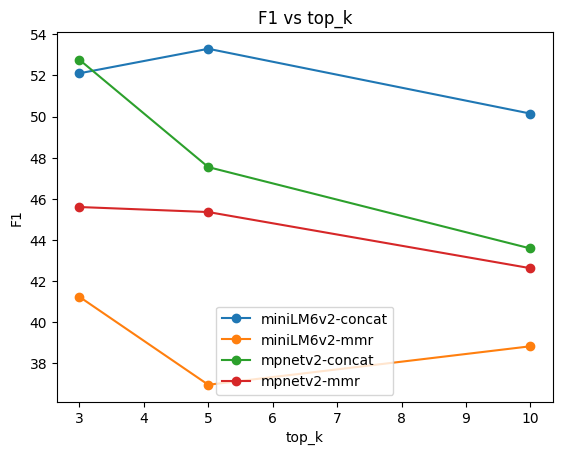

In [ ]:
for (m, s), sub in df.groupby(["model","strategy"]):
    plt.plot(sub["top_k"], sub["f1"], marker="o", label=f"{m}-{s}")
plt.xlabel("top_k")
plt.ylabel("F1")
plt.title("F1 vs top_k")
plt.legend()
plt.show()
